# Att anpassa en funktion till ett diagram

I denna övning ska vi pröva på att anpassa en funktion till ett histogram. Funktionsanpassning är ett mycket användbart verktyg när man vill simplifiera statistik för beräkningar, eller jämföra resultat med en teoretisk modell. Inom partikelfysiken är detta användbart när vi vill avgöra position, höjd och bredd för en pik i ett histogram.

Innan du tacklar detta exempel rekommederas att du har bekantat dig med dokumentet **Intro 3: Funktionsanpassning i Python**.

Vi utgår från CMS' partikelfysikdata gällande sådana kollisioner där två myoner uppstår. Datafilen *Dimuon_DoubleMu.csv* är hämtad från CERN:s opendata-portal och kan hittas i samma mapp som denna notebook.

## Hämta och rita data

Vi börjar med att ta in de relevanta funktionspaketen och läsa in datafilen.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('Dimuon_DoubleMu.csv')
data.head()

,Run,Event,type1,E1,px1,py1,pz1,pt1,eta1,phi1,...,type2,E2,px2,py2,pz2,pt2,eta2,phi2,Q2,M
0,165617,74601703,G,9.6987,-9.5104,0.3662,1.8633,9.5175,0.1945,3.1031,...,G,9.7633,7.3277,-1.1524,6.3473,7.4178,0.7756,-0.1560,1,17.4922
1,165617,75100943,G,6.2039,-4.2666,0.4565,-4.4793,4.2910,-0.9121,3.0350,...,G,9.6690,7.2740,-2.8211,-5.7104,7.8019,-0.6786,-0.3700,1,11.5534
2,165617,75587682,G,19.2892,-4.2121,-0.6516,18.8121,4.2622,2.1905,-2.9881,...,G,9.8244,4.3439,-0.4735,8.7985,4.3697,1.4497,-0.1086,1,9.1636
3,165617,75660978,G,7.0427,-6.3268,-0.2685,3.0802,6.3325,0.4690,-3.0992,...,G,5.5857,4.4748,0.8489,-3.2319,4.5546,-0.6605,0.1875,1,12.4774
4,165617,75947690,G,7.2751,0.1030,-5.5331,-4.7212,5.5340,-0.7736,-1.5522,...,G,7.3181,-0.3988,6.9408,2.2825,6.9523,0.3227,1.6282,1,14.3159


Sedan ritar vi in statistiken från kolumnen **M** (Myonernas sammanlagda massa, mätt i GeV) i ett histogram.

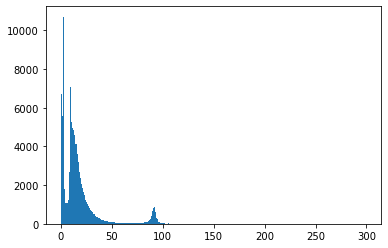

In [2]:
plt.hist(data['M'], bins=300)
plt.show()

Vi märker att datan har en liten pik mellan 80 och 100 GeV, så vi vill rita ett nytt histogram över detta intervall. Obs: Denna gång sparar vi `plt.hist()`-funktionens värden. Funktionen återger tre värden, och vi vill använda de två första; staplarnas höjder (antal händelser) och gränser.



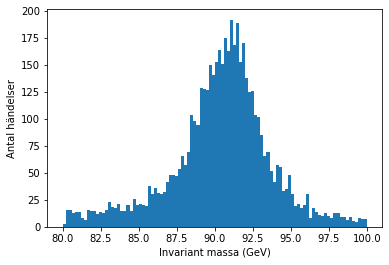

In [3]:
undre_grans = 80      # Pro tip: Dessa värden kan skrivas in direkt i koden nedan, men det är praktiskt att
ovre_grans = 100      #  samla parametrar på ett ställe ifall man vill justera något i efterhand.
antal_staplar = 100   # Då behöver man inte söka genom koden för att se var man borde ändra

plt.figure()
handelser, granser, _ = plt.hist(data['M'], bins=antal_staplar, range=(undre_grans, ovre_grans))
plt.xlabel('Invariant massa (GeV)')
plt.ylabel('Antal händelser')
plt.show()

## Skapa en modell för funktionen

Vi vill anpassa en funktion till fördelningen ovan. Inom partikelfysik används ofta [Breit-Wigner -fördelningen](https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution) - en fördelning som påminner om normalfördelningen. I detta exempel använder vi dock Gauss' normalfördelning, eftersom den är bekant. 

Normalfördelningens allmänna funktion med standardavvikelsen $\sigma$ och medelvärdet $\mu$ ser ut så här:

$$f(x) = \frac{1}{\sigma \sqrt{2\pi}}{e^{\frac{-(x-\mu)^2}{2\sigma^2}}}$$

Vi *kan* anpassa den allmänna normalfördelningen till statistiken, men vi får ett betydligt bättre resultat om vi beaktar bakgrundsstrålningen också. Vi kan anta att bakgrundsstrålningen avtar linjärt i intervallet, så som skissen nedan antyder. Vi vill alltså lägga till en linjär funktion $bx + c$ till fördelningen.

<img src="files/taustasateily.PNG" width=400>

Funktionen som ska anpassas blir då

$$f(x) = ae^{\frac{-(x-\mu)^2}{2\sigma^2}} + bx + c$$

där $a$ är en koefficient som ersätter $\frac{1}{\sigma \sqrt{2\pi}}$, $\mu$ är väntevärdet, $\sigma^2$ variansen och $bx$ och $c$ är bakgrundsstrålningen.

Vi definierar funktionen i python. Denna funktion har 5 obekanta variabler, så utan hjälpmedel skulle vi inte ha någon annan möjlighet än att gissa oss fram till en anpassning. Python klarar optimeringen fint.

In [4]:
import numpy as np

def gauss(x, *p):
    a, mu, sigma, b, c = p
    return a*np.exp(-(x-mu)**2/(2.*sigma**2)) + b*x + c

## Anpassa funktionen

Nu ska vi anpassa funktionen med hjälp av **scipy**-paketets **optimize.curve_fit**-kommando. Vi börjar med att bestämma staplarnas mittvärden, så att anpassningen träffar rätt.

Väntevärde =  90.8583262531103
Pikbredd =  4.493052846553603


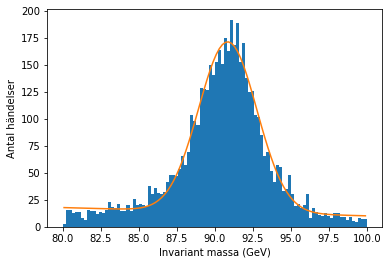

In [6]:
from scipy.optimize import curve_fit

# Vi får staplarnas mitt genom att beräkna medelvärdet av deras gränser
medel = (granser[:-1] + granser[1:])/2

# För att göra en anpassning behövs någon sorts startvärden.
# Vi gissar rimliga värden på a, mu, sigma, b och c i den ordningen.
p0 = [100, 90, 1, 1, 1]

# Vi beräknar de optimala koefficienterna 
koefficienter, _ = curve_fit(gauss, medel, handelser, p0=p0)

# Vi beräknar en anpassning med hjälp av koefficienterna
anpassning = gauss(medel, *koefficienter)

# Vi ritar ut histogramet tillsammans med den anpassade funktionen.
plt.hist(data['M'], bins=antal_staplar, range=(undre_grans, ovre_grans))
plt.plot(medel, anpassning, label='anpassning')
plt.xlabel('Invariant massa (GeV)')
plt.ylabel('Antal händelser')

# Vi skriver ut väntevärdet och pikens bredd (FWHM, https://sv.wikipedia.org/wiki/Halvv%C3%A4rdesbredd)
print('Väntevärde = ', koefficienter[1])
print('Pikbredd = ', 2*np.sqrt(2*np.log(2))*koefficienter[2])

plt.show()

Med dessa resultat som grund kan vi uppskatta Z-bosonens massa till 90,86 GeV. Du kan testa själv: Hur ser anpassningen ut om du tar bort den linjära korrigeringen av bakgrundsstrålningen, eller om du använder [Breit-Wigner -fördelningen](https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution) istället? Ger Breit-Wigners en bättre anpassning än Gauss' fördelning? Du kan också testa hur antalet staplar kan påverka resultatet.